In [1]:
import sys
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from spender import SpectrumAutoencoder
from spender.data import desi
import matplotlib.pyplot as plt

/Users/ng27753/Astronomy_Research/spender/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def build_wave_rest(instrument, z_max):
    # Match the logic in train_DESI_noise.py
    if z_max > 0.01:  # BGS-style
        lmbda_min = instrument.wave_obs[0] / (1.0 + z_max)
        lmbda_max = instrument.wave_obs[-1]
        bins = 9780
    else:
        lmbda_min = instrument.wave_obs[0] / (1.0 + z_max)
        lmbda_max = instrument.wave_obs[-1]
        bins = int((lmbda_max-lmbda_min).item()/0.8)
    wave_rest = torch.linspace(lmbda_min, lmbda_max, bins, dtype=torch.float32)
    return wave_rest

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
inst = desi.DESI()
wave_rest = build_wave_rest(inst, 0)

# Same arch as in train_DESI_noise.py
n_hidden = (64, 256, 1024)
model = SpectrumAutoencoder(
    inst,
    wave_rest,
    n_latent=10,
    n_hidden=n_hidden,
    act=[torch.nn.LeakyReLU()] * (len(n_hidden) + 1),
).to(device)

# load the model checkpoint
ckpt = torch.load('../desi_noise_spender_10latent.pt', map_location=device, weights_only=False)
state_dict = ckpt["model"][0]  # first (and only) encoder/decoder
model.load_state_dict(state_dict)
model.eval()

# data loader
loader = inst.get_data_loader(
    '../DATA',
    tag="chunk1024",
    which="all",
    batch_size=64,
    shuffle=False,
    shuffle_instance=False,
)

In [ ]:
latents = []
decodes = []
snrs = []
weights = []
w_s = []
spectra = []

In [99]:
recon.shape, snr.shape

(torch.Size([64, 7780]), torch.Size([64, 7781]))

In [19]:
with torch.no_grad():
    for i, batch in enumerate(loader):
        spec, w, z, target_id,  norm, zerr = batch
        snr = spec * torch.sqrt(w)
        snr = snr.to(device)
        snrs.append(snr.cpu().numpy())

        # mask out zero-weighted pixels
        weight = torch.ones_like(w)
        weight[w == 0] = 0
        weights.append(weight.cpu().numpy())

        s = model.encode(snr)
        latents.append(s.cpu().numpy())

        recon = model.decode(s)
        decodes.append(recon.cpu().numpy())

        w_s.append(w.cpu().numpy())
        spectra.append(spec.cpu().numpy())
        break

In [71]:
import numba
import numpy as np

def centers2edges(centers):
    """Convert bin centers to bin edges, guessing at what you probably meant
    Args:
        centers (array): bin centers,
    Returns:
        array: bin edges, lenth = len(centers) + 1
    """
    centers = np.asarray(centers)
    edges = np.zeros(len(centers)+1)
    #- Interior edges are just points half way between bin centers
    edges[1:-1] = (centers[0:-1] + centers[1:]) / 2.0
    #- edge edges are extrapolation of interior bin sizes
    edges[0] = centers[0] - (centers[1]-edges[1])
    edges[-1] = centers[-1] + (centers[-1]-edges[-2])

    return edges

@numba.jit
def _trapz_rebin(x, y, edges, results):
    '''
    Numba-friendly version of trapezoidal rebinning
    See redrock.rebin.trapz_rebin() for input descriptions.
    `results` is pre-allocated array of length len(edges)-1 to keep results
    '''
    nbin = len(edges) - 1
    i = 0  #- index counter for output
    j = 0  #- index counter for inputs
    yedge = 0.0
    area = 0.0

    while i < nbin:
        #- Seek next sample beyond bin edge
        while x[j] <= edges[i]:
            j += 1

        #- What is the y value where the interpolation crossed the edge?
        yedge = y[j-1] + (edges[i]-x[j-1]) * (y[j]-y[j-1]) / (x[j]-x[j-1])

        #- Is this sample inside this bin?
        if x[j] < edges[i+1]:
            area = 0.5 * (y[j] + yedge) * (x[j] - edges[i])
            results[i] += area

            #- Continue with interior bins
            while x[j+1] < edges[i+1]:
                j += 1
                area = 0.5 * (y[j] + y[j-1]) * (x[j] - x[j-1])
                results[i] += area

            #- Next sample will be outside this bin; handle upper edge
            yedge = y[j] + (edges[i+1]-x[j]) * (y[j+1]-y[j]) / (x[j+1]-x[j])
            area = 0.5 * (yedge + y[j]) * (edges[i+1] - x[j])
            results[i] += area

        #- Otherwise the samples span over this bin
        else:
            ylo = y[j] + (edges[i]-x[j]) * (y[j] - y[j-1]) / (x[j] - x[j-1])
            yhi = y[j] + (edges[i+1]-x[j]) * (y[j] - y[j-1]) / (x[j] - x[j-1])
            area = 0.5 * (ylo+yhi) * (edges[i+1]-edges[i])
            results[i] += area

        i += 1

    for i in range(nbin):
        results[i] /= edges[i+1] - edges[i]

    return

def trapz_rebin(x, y, xnew=None, edges=None):
    """Rebin y(x) flux density using trapezoidal integration between bin edges
    Notes:
        y is interpreted as a density, as is the output, e.g.
        >>> x = np.arange(10)
        >>> y = np.ones(10)
        >>> trapz_rebin(x, y, edges=[0,2,4,6,8])  #- density still 1, not 2
        array([ 1.,  1.,  1.,  1.])
    Args:
        x (array): input x values.
        y (array): input y values.
        edges (array): (optional) new bin edges.
    Returns:
        array: integrated results with len(results) = len(edges)-1
    Raises:
        ValueError: if edges are outside the range of x or if len(x) != len(y)
    """
    if edges is None:
        edges = centers2edges(xnew)
    else:
        edges = np.asarray(edges)

    if edges[0] < x[0] or x[-1] < edges[-1]:
        raise ValueError('edges must be within input x range')

    result = np.zeros(len(edges)-1, dtype=np.float64)

    _trapz_rebin(x, y, edges, result)

    return result

[30 57 40 58 20 13]


Text(0.5, 0, '$\\lambda_{\\mathrm{rest}}$ [Å]')

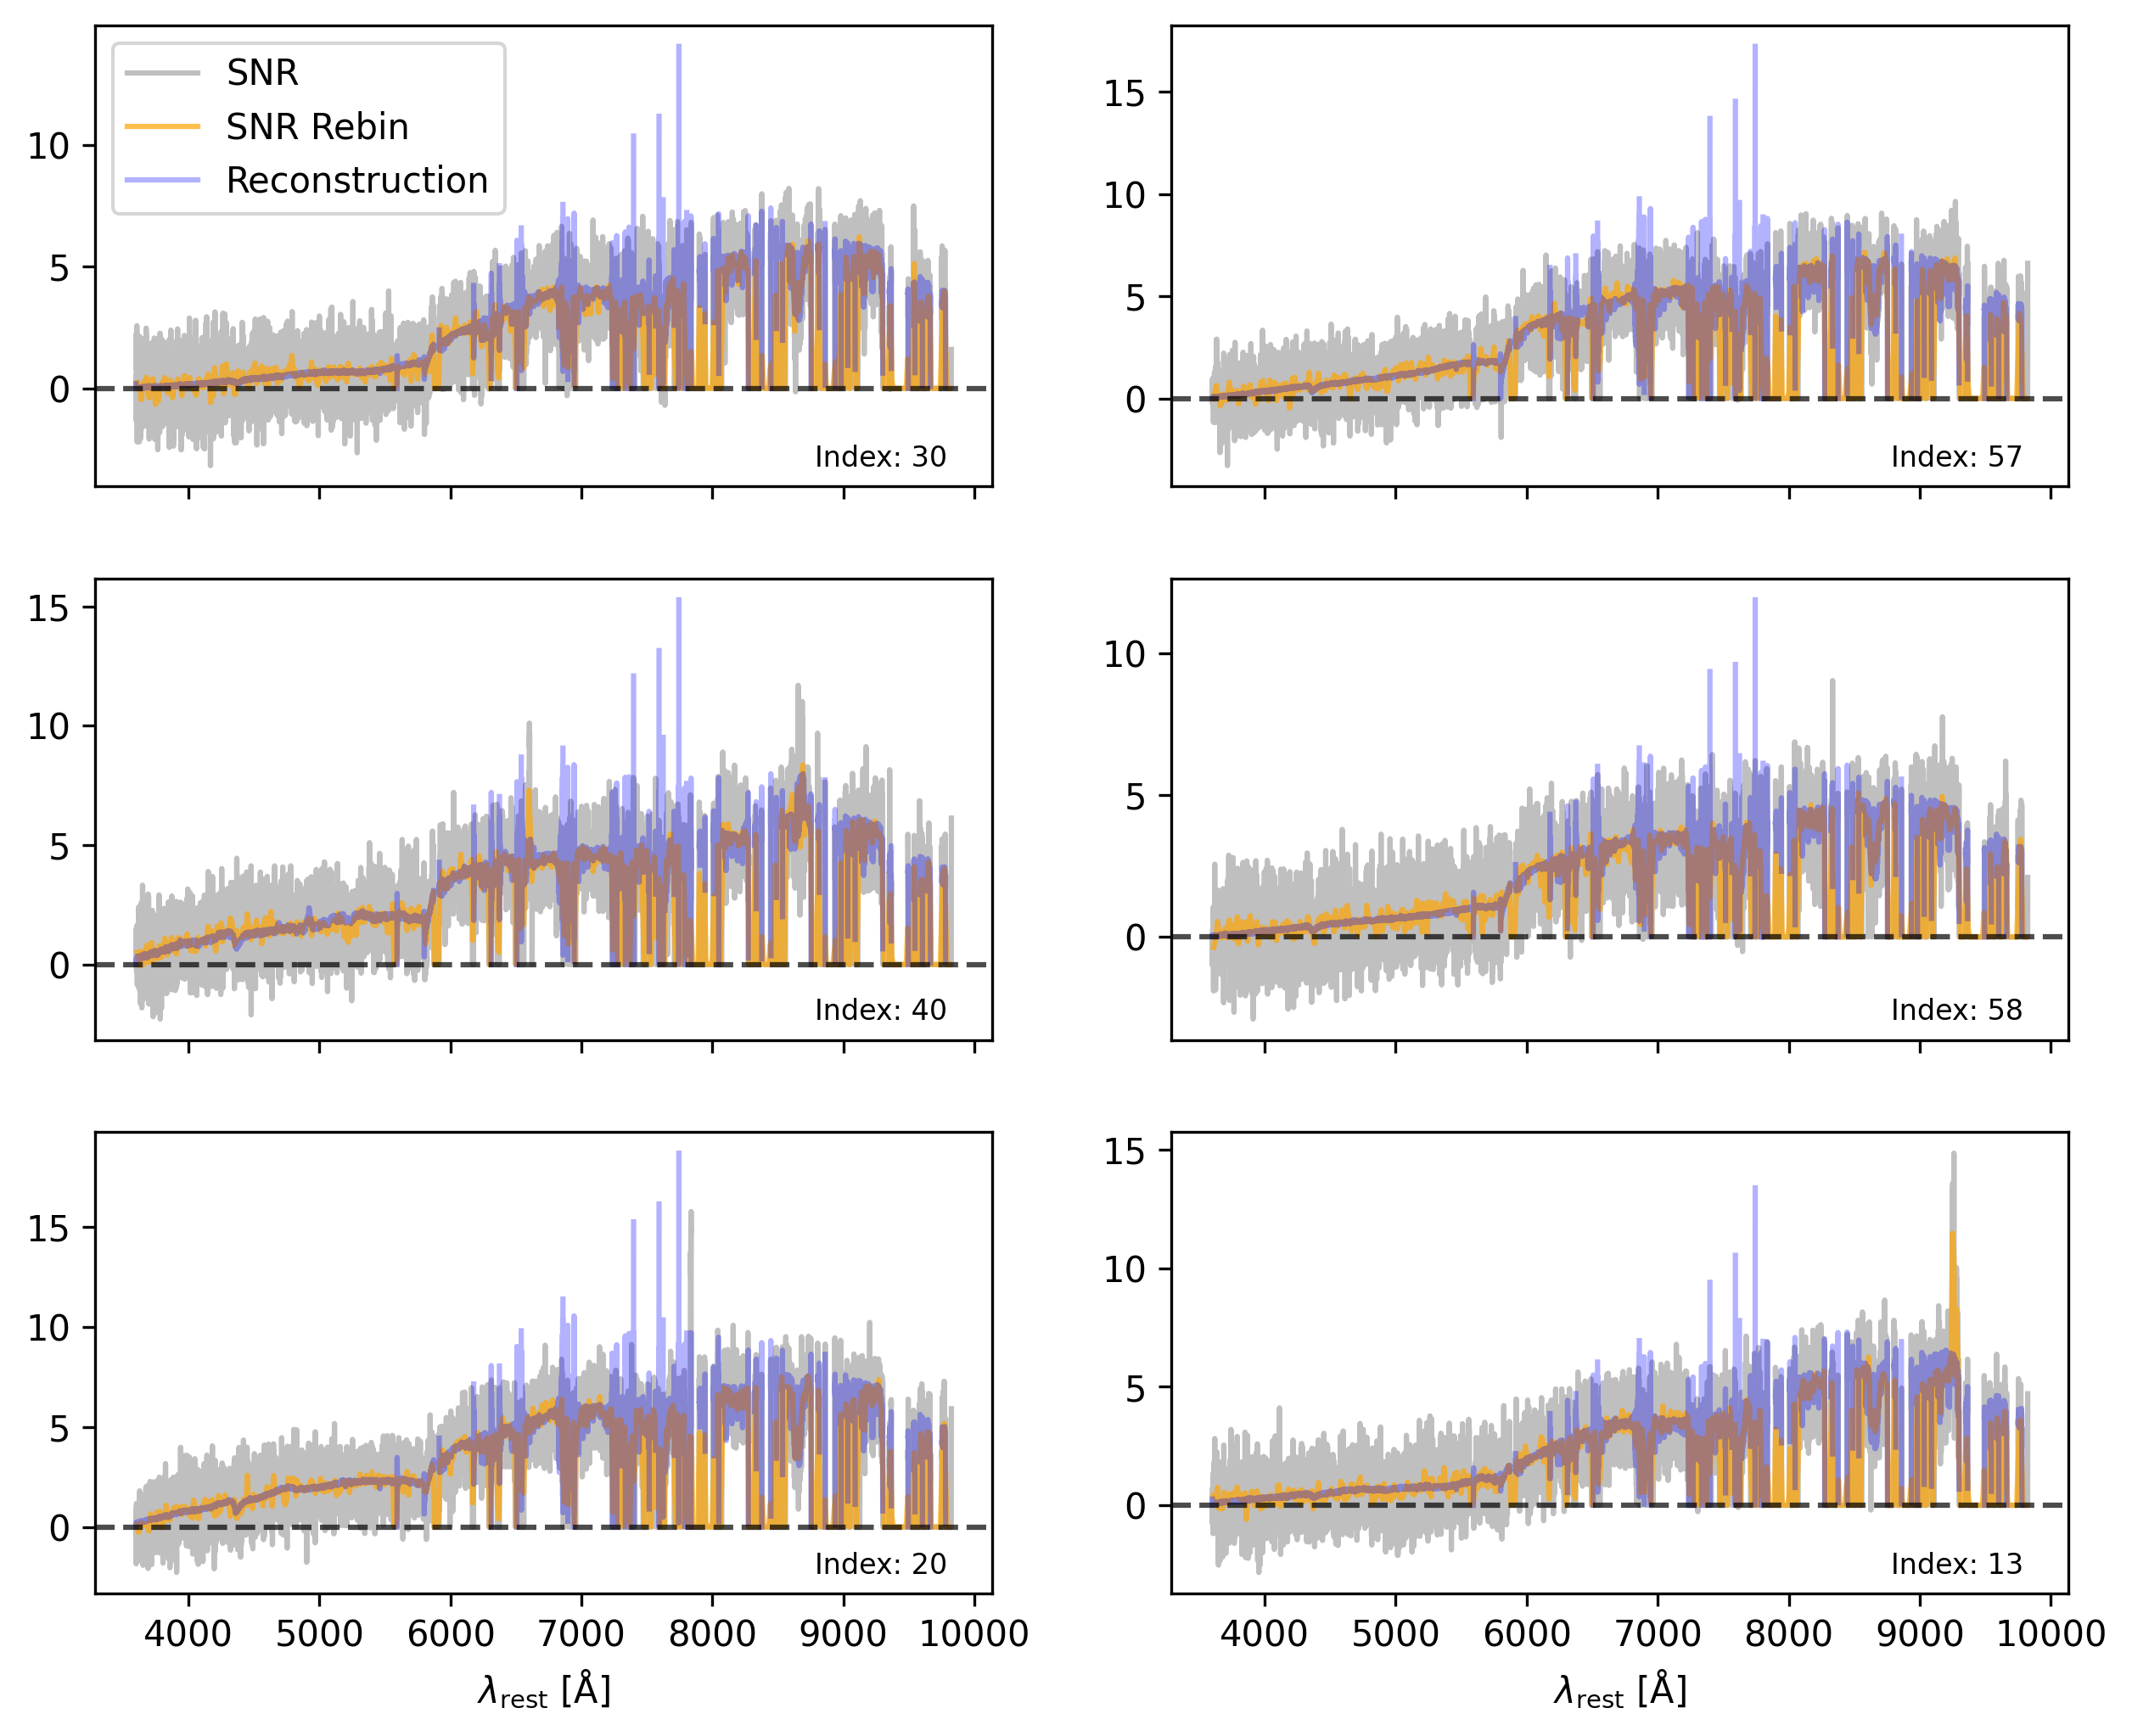

In [76]:
fig, ax = plt.subplots(3, 2, figsize=(10, 8), sharex=True, dpi=300)
ax = ax.flatten()

# get random index
idx = np.random.randint(0, snrs[0].shape[0], size=6)
print(idx)

wave_rebin = np.arange(model.wave_obs[0], model.wave_obs[-1], 10)[1:-1]

for i in range(6):
    index = idx[i]
    ax[i].plot(model.wave_obs, snrs[0][index], label='SNR', color='gray', alpha=0.5)
    snr_rebin = trapz_rebin(np.array(model.wave_obs), np.array(snrs[0][index]), xnew=wave_rebin)
    ax[i].plot(wave_rebin, snr_rebin, label='SNR Rebin', color='orange', alpha=0.7)
    # mask out w_s[0][i] == 0 to nan
    mask = w_s[0][index][:-1] == 0
    reconstructed = decodes[0][index].copy()
    reconstructed[mask] = np.nan
    ax[i].plot(model.wave_obs[:-1], reconstructed, label='Reconstruction', color='blue', alpha=0.3)
    ax[i].axhline(y=0, color='black', linestyle='--', alpha=0.7)
    # text bottom right with index
    ax[i].text(0.95, 0.03, f'Index: {index}', transform=ax[i].transAxes,
               horizontalalignment='right', verticalalignment='bottom', fontsize=8)
ax[0].legend()

ax[-1].set_xlabel(r'$\lambda_{\mathrm{rest}}$ [Å]')
ax[-2].set_xlabel(r'$\lambda_{\mathrm{rest}}$ [Å]')

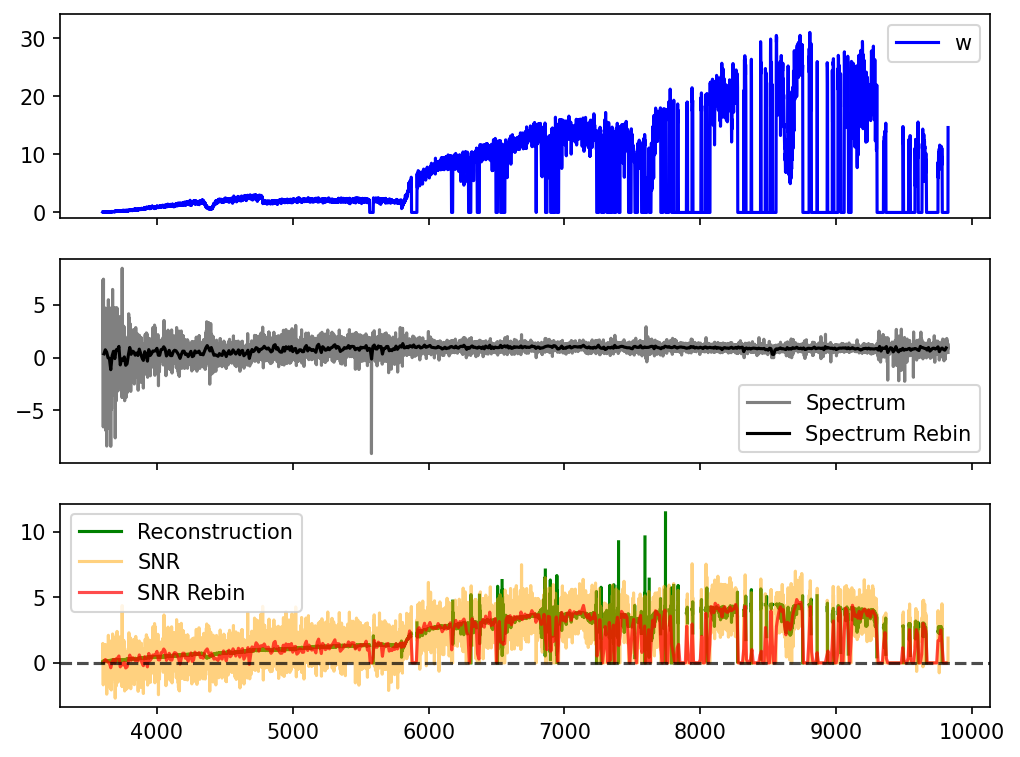

In [107]:
mask = w_s[0][1][:-1] == 0
d = decodes[0][1].copy()
d[mask] = np.nan

spectra_rebin = trapz_rebin(np.array(model.wave_obs), np.array(spectra[0][1]), xnew=wave_rebin)
snr_rebin = trapz_rebin(np.array(model.wave_obs), np.array(snrs[0][1]), xnew=wave_rebin)

fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True, dpi=150)

ax[0].plot(model.wave_obs, w_s[0][1], label='w', color='blue')
ax[0].set_ylim(-1, np.nanmax(w_s[0][1])*1.1)

ax[1].plot(model.wave_obs, spectra[0][1], label='Spectrum', color='gray')
ax[1].plot(wave_rebin, spectra_rebin, label='Spectrum Rebin', color='black')

ax[2].plot(model.wave_obs[:-1], d, label='Reconstruction', color='green')
ax[2].plot(model.wave_obs, snrs[0][1], label='SNR', color='orange', alpha=0.5)
ax[2].plot(wave_rebin, snr_rebin, label='SNR Rebin', color='red', alpha=0.7)
ax[-1].axhline(y=0, color='black', linestyle='--', alpha=0.7)

ax[0].legend()
ax[1].legend()
ax[2].legend()